In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import math
from collections import OrderedDict
import residuals as r

%matplotlib inline
import matplotlib.gridspec as gridspec
plt.rcParams['font.family']='serif'

micro = 10**(6)

from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def weighted_stddev(values, errors):
    '''
    Return the weighted average and standard deviation.

    '''
    weights = 1. / ((errors)**2)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (math.sqrt(variance))

def magnitude(x):
    '''
    Return the magnitude of a variable
    '''
    var = float(x)
    return int(math.floor(math.log10(var)))

In [3]:
def make_arrays(psrname, MJDint):
    condition_lower=MJDint
    condition_upper=MJDint+0.99
    
    jitter_ratios = OrderedDict()
    corr_coefs = OrderedDict()
    file_names = []
    for elem in ['320','160','80', '40', '20', 'NT']:
        #Define sigma_all (or std_all) as entire observation period
        x=r.read_residuals(filename="/nimrod1/eschwab/residuals/%s_resid_%s_%sF8.tmp" %(psrname, MJDint, elem))
        
        condition = (x.bary_TOA > condition_lower) & (x.bary_TOA < condition_upper) & (x.bary_freq > 1221.0) & (x.bary_freq < 2000.0)
        Resid_all = x.prefit_sec[condition]
        Errors_all = x.uncertainty[condition]
        std_all = weighted_stddev(Resid_all, Errors_all)

        ##============

        #Define sigma_dump (or std_all) as individual dumps within observation period

        #This isolates the numbers for the different dump times
        rounded = np.round(np.array([x.bary_TOA[condition] - 0.00005]), 4)
        dumptimes=[]
        for i in rounded.tolist()[0]: 
            if i not in dumptimes:
                dumptimes.append(i)

        #This calculates a list of sigma_dump values and averages those
        str_dump_devs=[]
        for i in dumptimes:
            timeindex = (rounded == i)[0]
            Resid = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            single_std_dump = weighted_stddev(Resid, Errors)
            str_dump_devs.append(single_std_dump)

        #to convert str_dump_devs out of scientific notation
        dump_devs=[]
        for i in str_dump_devs:
            dump_devs.append('{0:.20f}'.format(i))

        #prints the magnitude of each sigma_dump in a list and finds average magnitude
        magarray=[]
        for i in dump_devs:
            magarray.append(magnitude(i))
        averagemag = round(np.mean(magarray))

        arg=averagemag+1.5
        makemask = np.ma.masked_where(np.array(magarray) > arg, np.array(magarray))

        std_dump=np.mean(str_dump_devs)
        masked_std_dump = np.mean(np.ma.masked_where(np.ma.getmask(makemask), str_dump_devs))

        #Setup jitter ratio
        ratio = std_all / std_dump
        masked_ratio = float(std_all / masked_std_dump)
        jitter_ratios[elem] = masked_ratio

        ##============

        #Print out the correlation coefficient also, to allow for easy reference

        #Creating the matrix of the data and transposing it to correct format
        data = []
        data_errors = []
        for i in dumptimes[1:]: #the first set of resids needs to be skipped in J1713, but not sure for all of them?
            timeindex = (rounded == i)[0]
            Resids = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            data.append(Resids)
            data_errors.append(Errors)

        data = map(list, zip(*data)) #transposing the matrix, supposedly unnecessary if rowvar=0 in corr but gives errors

        #Using the Weighted Correlation Coefficient from wikipedia
        #https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient#Weighted_correlation_coefficient
        # I added weights by creating a weighted value to multiply each data element by
        #The weighted values are normalized by dividing each value by the sum of all weights

        data_weights = 1. / (np.array(data_errors)**2)
        data_weights = map(list, zip(*(data_weights.tolist())))

        #data_weights is a matrix of all the weights

        norm_weights = []
        for i in data_weights:
            norm_weights.append([j/sum(i) for j in i])

        weighted_data = []
        for i,j in zip(data, norm_weights):
            weighted_data.append([a*b for a,b in zip(i,j)])

        #Correlating! 
        corr = np.corrcoef(data)
        weighted_corr = np.corrcoef(weighted_data)

        unique_corrs = []
        #Averaging the correlation
        for i in range(len(corr)):
            unique_corrs.append(corr[i][i+1:]) #because numpy array, double index necessay
        unique_corrs  = [val for sublist in unique_corrs for val in sublist]
        final_coefficient = np.average(unique_corrs)

        unique_weighted_corrs = []
        #Averaging the correlation
        for i in range(len(weighted_corr)):
            unique_weighted_corrs.append(weighted_corr[i][i+1:]) #because numpy array, double index necessay
        unique_weighted_corrs  = [val for sublist in unique_weighted_corrs for val in sublist]
        final_weighted_coefficient = np.average(unique_weighted_corrs)
        
        corr_coefs[elem] = final_coefficient

    return jitter_ratios, corr_coefs

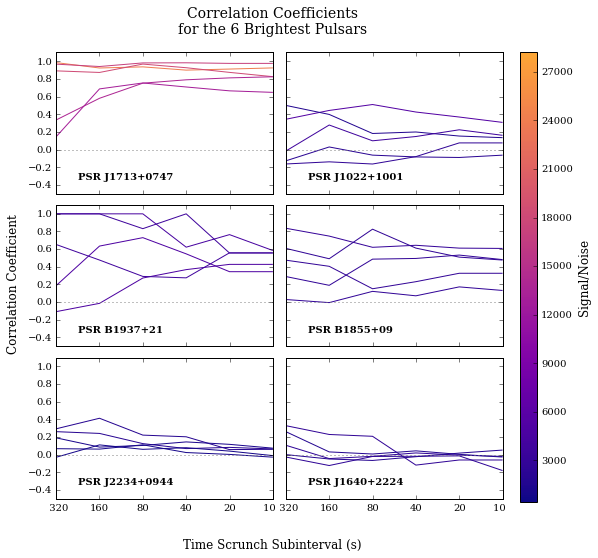

In [8]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap


#Define the overall plot, title and spacing
#figsize(6,11)
fig, ax = plt.subplots(figsize=(8, 8), nrows=3, ncols=2, sharex=True, sharey=True)
fig.suptitle('Correlation Coefficients\nfor the 6 Brightest Pulsars', fontsize=14)
plt.subplots_adjust(wspace=0.06, hspace=0.08)

# Evaluate an existing colormap from 0.5 (midpoint) to 1 (upper end)
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 0.8, cmap.N // 2))
cmap = LinearSegmentedColormap.from_list('Lower Part', colors)

X=range(0,5)
C=range(0,5)
ticks=['  320', '160', '80', '40', '20', '10  ']

##== Defining the first subplot - J1713 ==##

days=(57305, 57302, 56380, 57319, 57041)
SNR=(23922.71, 18328.92, 17140.46, 13989.67, 13117.22)
plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('J1713+0747', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]

x=[]
y=[]
z=[]
for SNRval, data_dict in plotcorr.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(SNRval)
    
x=np.array(x)
y=np.array(y)


prelines=np.array(zip(x,y))
lines = [zip(x,y) for x,y in prelines]

#Normalizing the color for highest and lowest SNR
for _ in range(0,2):
    lines.append([(-2.0, 500), (-3.0, 500)])
    
for ii in (28200.0, 450.0):
    z.append(ii)
z=np.array(z)


lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
ax[0,0].add_collection(lines)
ax[0,0].axhline(0, color='grey', linestyle=":")

ax[0,0].annotate('PSR J1713+0747', xy=(0.1, 0.15), xycoords='axes fraction', 
                    fontweight='bold', horizontalalignment='left', verticalalignment='top')
        
ax[0,0].set_xlim(0,5)
ax[0,0].set_ylim(-0.5,1.1)
ax[0,0].set_xticklabels(ticks)
ax[0,0].yaxis.set_major_locator(MaxNLocator(prune='lower'))

##== Defining the second subplot - J1022 ==##

days=(57028, 57084, 57126, 57146, 57187)#, 57256, 57312, 57331)
SNR=(2682.06, 5431.66, 1708.91, 2212.29, 3914.98)#, 1598.94, 2484.67, 7082.63)
plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('J1022+1001', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]

x=[]
y=[]
z=[]
for SNRval, data_dict in plotcorr.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(SNRval)
    
x=np.array(x)
y=np.array(y)

prelines=np.array(zip(x,y))
lines = [zip(x,y) for x,y in prelines]

#Normalizing the color for highest and lowest SNR
for _ in range(0,2):
    lines.append([(-2.0, 500), (-3.0, 500)])
    
for ii in (28200.0, 450.0):
    z.append(ii)
z=np.array(z)

lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
ax[0,1].add_collection(lines)
ax[0,1].axhline(0, color='grey', linestyle=":")

ax[0,1].annotate('PSR J1022+1001', xy=(0.1, 0.15), xycoords='axes fraction', 
                    fontweight='bold', horizontalalignment='left', verticalalignment='top')

##== Defining the second subplot - B1937 ==##

days=(56325, 56531, 56613, 56425, 56634)
SNR=(5066.58, 4960.2, 4540.29, 3947.15, 3723.2)
plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('B1937+21', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]

x=[]
y=[]
z=[]
for SNRval, data_dict in plotcorr.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(SNRval)
    
x=np.array(x)
y=np.array(y)

prelines=np.array(zip(x,y))
lines = [zip(x,y) for x,y in prelines]

#Normalizing the color for highest and lowest SNR
for _ in range(0,2):
    lines.append([(-2.0, 500), (-3.0, 500)])
    
for ii in (28200.0, 450.0):
    z.append(ii)
z=np.array(z)

lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
ax[1,0].add_collection(lines)
ax[1,0].axhline(0, color='grey', linestyle=":")

ax[1,0].annotate('PSR B1937+21', xy=(0.1, 0.15), xycoords='axes fraction', 
                    fontweight='bold', horizontalalignment='left', verticalalignment='top')

##== Defining the second subplot - B1937 ==##

days=(56640, 56479, 56977, 57028, 57305)#, 57186)
SNR=(3148.03, 2850.75, 2777.17, 2736.53, 2701.53)#, 2450.28)
plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('B1855+09', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]

x=[]
y=[]
z=[]
for SNRval, data_dict in plotcorr.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(SNRval)
    
x=np.array(x)
y=np.array(y)

prelines=np.array(zip(x,y))
lines = [zip(x,y) for x,y in prelines]

#Normalizing the color for highest and lowest SNR
for _ in range(0,2):
    lines.append([(-2.0, 500), (-3.0, 500)])
    
for ii in (28200.0, 450.0):
    z.append(ii)
z=np.array(z)

lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
ax[1,1].add_collection(lines)
ax[1,1].axhline(0, color='grey', linestyle=":")

ax[1,1].annotate('PSR B1855+09', xy=(0.1, 0.15), xycoords='axes fraction', 
                    fontweight='bold', horizontalalignment='left', verticalalignment='top')

##== Defining the second subplot - J2234 ==##

days=(57240, 57306, 57096, 56935, 56599)#, 57186)
SNR=(2028.22, 1941.02, 1241.21, 998.48, 912.77)#, 870.55)
plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('J2234+0944', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]

x=[]
y=[]
z=[]
for SNRval, data_dict in plotcorr.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(SNRval)
    
x=np.array(x)
y=np.array(y)

prelines=np.array(zip(x,y))
lines = [zip(x,y) for x,y in prelines]

# Normalizing the color for highest and lowest SNR
for _ in range(0,2):
    lines.append([(-2.0, 500), (-3.0, 500)])
    
for ii in (28200.0, 450.0):
    z.append(ii)
z=np.array(z)

lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
ax[2,0].add_collection(lines)
ax[2,0].axhline(0, color='grey', linestyle=":")

ax[2,0].annotate('PSR J2234+0944', xy=(0.1, 0.15), xycoords='axes fraction', 
                    fontweight='bold', horizontalalignment='left', verticalalignment='top')

##== Defining the second subplot - J1640 ==##

days=(56537, 57147, 57320, 56977, 56853)
SNR=(2656.74, 2547.67, 2522.14, 1926.91, 1843.72)
plotjitter=OrderedDict()
plotcorr=OrderedDict()
for ii,jj in zip(days, SNR):
    arrays=make_arrays('J1640+2224', ii) #arrays[0] is jitter, arrays[1] is corr
    plotjitter[jj]=arrays[0]
    plotcorr[jj]=arrays[1]

x=[]
y=[]
z=[]
for SNRval, data_dict in plotcorr.iteritems():
    x.append(range(len(data_dict)))
    y.append(data_dict.values())
    z.append(SNRval)
    
x=np.array(x)
y=np.array(y)

prelines=np.array(zip(x,y))
lines = [zip(x,y) for x,y in prelines]

#Normalizing the color for highest and lowest SNR
for _ in range(0,2):
    lines.append([(-2.0, 500), (-3.0, 500)])
    
for ii in (28200.0, 450.0):
    z.append(ii)
z=np.array(z)

lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
ax[2,1].add_collection(lines)
ax[2,1].axhline(0, color='grey', linestyle=":")

ax[2,1].annotate('PSR J1640+2224', xy=(0.1, 0.15), xycoords='axes fraction', 
                    fontweight='bold', horizontalalignment='left', verticalalignment='top')

# #== Defining the subplot - J1944 ==##

# days=(56868, 57316, 56668)
# SNR=(1547.49, 1512.43, 1477.98)
# plotjitter=OrderedDict()
# plotcorr=OrderedDict()
# for ii,jj in zip(days, SNR):
#     arrays=make_arrays('J1944+0907', ii) #arrays[0] is jitter, arrays[1] is corr
#     plotjitter[jj]=arrays[0]
#     plotcorr[jj]=arrays[1]

# x=[]
# y=[]
# z=[]
# for SNRval, data_dict in plotcorr.iteritems():
#     x.append(range(len(data_dict)))
#     y.append(data_dict.values())
#     z.append(SNRval)
    
# x=np.array(x)
# y=np.array(y)

# prelines=np.array(zip(x,y))
# lines = [zip(x,y) for x,y in prelines]

# #Normalizing the color for highest and lowest SNR
# for _ in range(0,2):
#     lines.append([(-2.0, 500), (-3.0, 500)])
    
# for ii in (28200.0, 450.0):
#     z.append(ii)
# z=np.array(z)

# lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
# ax[3,0].add_collection(lines)
# ax[3,0].axhline(0, color='grey', linestyle=":")

# ax[3,0].annotate('PSR J1944+0907', xy=(0.1, 0.15), xycoords='axes fraction', 
#                     fontweight='bold', horizontalalignment='left', verticalalignment='top')


# #== Defining the subplot - J2317 ==##

# days=(57355, 57335)#, 57273, 56265, 56280, 57018, 56140, 57096)
# SNR=(1972.56, 1964.3)#, 1765.74, 1613, 1593.08, 1542.37, 1489.35, 1319.48)
# plotjitter=OrderedDict()
# plotcorr=OrderedDict()
# for ii,jj in zip(days, SNR):
#     arrays=make_arrays('J2317+1439', ii) #arrays[0] is jitter, arrays[1] is corr
#     plotjitter[jj]=arrays[0]
#     plotcorr[jj]=arrays[1]

# x=[]
# y=[]
# z=[]
# for SNRval, data_dict in plotcorr.iteritems():
#     x.append(range(len(data_dict)))
#     y.append(data_dict.values())
#     z.append(SNRval)
    
# x=np.array(x)
# y=np.array(y)

# prelines=np.array(zip(x,y))
# lines = [zip(x,y) for x,y in prelines]

# #Normalizing the color for highest and lowest SNR
# for _ in range(0,2):
#     lines.append([(-2.0, 500), (-3.0, 500)])
    
# for ii in (28200.0, 450.0):
#     z.append(ii)
# z=np.array(z)

# lines = LineCollection(lines, array=z, cmap=cmap, linewidths=1)
# ax[3,1].add_collection(lines)
# ax[3,1].axhline(0, color='grey', linestyle=":")

# ax[3,1].annotate('PSR J2317+1439', xy=(0.1, 0.15), xycoords='axes fraction', 
#                     fontweight='bold', horizontalalignment='left', verticalalignment='top')

# ax[3,1].plot(X, C, linewidth=1.0, linestyle="-")
# ax[4,0].plot(X, C, linewidth=1.0, linestyle="-")
# ax[4,1].plot(X, C, linewidth=1.0, linestyle="-")

cax = fig.add_axes([0.93, 0.12, 0.03, 0.78]) #this locates the axis that is used for your colorbar. It is scaled 0 - 1. 
cb = fig.colorbar(lines, cax, orientation = 'vertical')
cb.set_label('Signal/Noise', fontsize='12')

fig.text(0.5, 0.04, 'Subinterval Duration (s)', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Correlation Coefficient', va='center', rotation='vertical', fontsize=12)

plt.show()